In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [13]:
import torch
import torch.nn.functional as F
import torchvision.models as M
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score, adjusted_rand_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython import display

from lateral_connections import LateralModel, VggModel, CustomImageDataset

model_path = 'models/VGG19_normalized_avg_pool_pytorch'
vm = VggModel(model_path, torch.device('cuda'), important_layers=[None])

vm.net


vgg = M.vgg19(pretrained=True,progress=True)


2


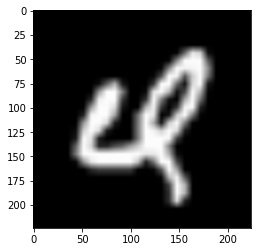

In [2]:
import PIL as pillow
import torchvision
from torchvision.datasets import MNIST

def transform_pillow_to_torch(x):
    x = x.resize((224,224), resample=pillow.Image.BILINEAR).convert('RGB')
    return torchvision.transforms.ToTensor()(x)

def plt_t(x):
    plt.imshow(torch.swapaxes(x,0,2))

ds = MNIST('images/mnist/', download=True, transform=transform_pillow_to_torch)

#vgg.classifier[-1]

img, label = ds[np.random.choice(len(ds))]
img, label = ds[5]
print(label)

plt_t(img)

In [24]:


training_data = MNIST('images/mnist/', train=True, download=True, transform=transform_pillow_to_torch)
test_data = MNIST('images/mnist/', train=False, download=True, transform=transform_pillow_to_torch)

train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)

(len(training_data), len(test_data))

(60000, 10000)

In [25]:
vgg1 = M.vgg19(pretrained=True, progress=True)
vgg2 = M.vgg19(pretrained=True, progress=True)
vgg3 = M.vgg19(pretrained=True, progress=True)

vgg1.classifier = vgg1.classifier[:2]
vgg2.classifier = vgg2.classifier[:5]

vgg1.eval()
vgg2.eval()
vgg3.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [20]:
print(train_dataloader.batch_size)

with torch.no_grad():
    #for i, data in tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader)):
    inputs, labels = next(iter(train_dataloader))
    prediction = vgg1(inputs)
    
        


512


In [21]:
prediction

tensor([[0.2492, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7658, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9832, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9182],
        ...,
        [1.3047, 0.4236, 0.0000,  ..., 0.0000, 0.0000, 0.2319],
        [0.0968, 0.7739, 0.0000,  ..., 0.0000, 0.0000, 0.0532],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1351, 0.0381]])

## (Adjusted) Rand Index for KMeans Clustering of VGG19 Output

In [27]:
inputs, labels = next(iter(train_dataloader))

with torch.no_grad():
    for i, network in enumerate([vgg1, vgg2, vgg3]):
        prediction = network(inputs)

        clusterer = KMeans(n_clusters=np.unique(labels).shape[0], random_state=42)
        cluster_labels = clusterer.fit_predict(prediction)

        if i != 0:
            print('==========================================================')
        print(f"[VGG{i+1}] Rand Index:\t\t", round(rand_score(labels, cluster_labels),3))
        print(f"[VGG{i+1}] Adjusted Rand Index:\t", round(adjusted_rand_score(labels, cluster_labels),3))

None

[VGG1] Rand Index:		 0.911
[VGG1] Adjusted Rand Index:	 0.536
[VGG2] Rand Index:		 0.88
[VGG2] Adjusted Rand Index:	 0.358
[VGG3] Rand Index:		 0.846
[VGG3] Adjusted Rand Index:	 0.21


## Silhouette Plot for MNIST/VGG19

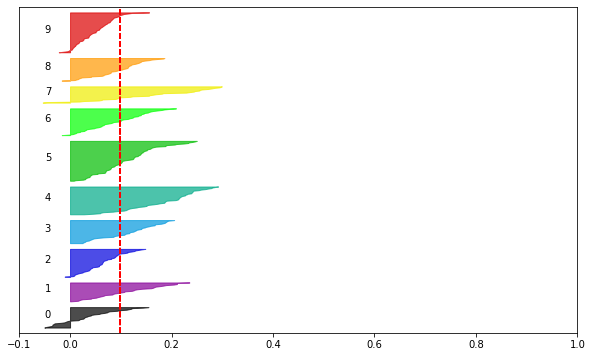

In [23]:
classes = np.unique(labels)
num_classes = classes.shape[0]


clusterer = KMeans(n_clusters=num_classes, random_state=42)
cluster_labels = clusterer.fit_predict(prediction)

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(prediction) + (num_classes + 1) * 10])

silhouette_avg = silhouette_score(prediction, cluster_labels)
sample_silhouette_values = silhouette_samples(prediction, cluster_labels)

y_lower=10
for i in sorted(classes):
    ith_c_sil_vals = sample_silhouette_values[cluster_labels == i]
    ith_c_sil_vals.sort()
    
    size_cluster_i = ith_c_sil_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / num_classes)
    
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_c_sil_vals,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    
    ax.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
    
    y_lower = y_upper+10
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
plt.show()